In [1]:
from six.moves import reload_module as reload
import sys
sys.path.append('../python')
from catfinder.loaders import load_train

In [2]:
from catfinder.loaders import util
dir(util)

['BytesIO',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'color',
 'find_largest_image_in_zip',
 'imread',
 'process_img_from_file',
 'reduce',
 'resize']

In [4]:
reload(load_train)

<module 'catfinder.loaders.load_train' from '../python/catfinder/loaders/load_train.py'>

In [5]:
[X,y] = load_train.load_numpy(10,10)

In [8]:
y.shape

(20,)

In [29]:
import os
# six is used for py2/py3 compatability
# PY3 is true if you are in Python3, else false. Used to guide the zip error import below.
# BytesIO gives us a file-like obect that can be opened by imread()
from six import PY3, BytesIO
# map/filter/reduce are lazily evaluated and run-once as in py3. 
# Also, since reduce moved between py2 and py3, this imports is correctly in either.
from six.moves import map, filter, reduce

import zipfile
from scipy.ndimage import imread
from skimage import color
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np
import re

train_zip_path = '../data/train.zip'

# I've run into this before, they changed this in the stdlib between python2 and 3.
if PY3:
    from zipfile import BadZipFile
else:
    from zipfile import error as BadZipFile

if not os.path.isfile(train_zip_path):
    raise Exception("Can't find train.zip")


In [2]:
from sklearn import datasets
iris = datasets.load_iris()

X, y = iris.data, iris.target
print(X.shape)
print(y.shape)

(150, 4)
(150,)


In [3]:
from operator import mul
jpg_re = re.compile(r'.*\.jp[e]?g$', re.IGNORECASE)


# Find the largest image, rather inefficiently.
largest_image = [0,0]

with zipfile.ZipFile(train_zip_path) as z:
    filelist = filter(jpg_re.match, z.namelist())
    # beware, this only applies to train.zip
    for f in filelist:
        color_img = imread(BytesIO(z.read(f)))
        s = color_img.shape[:2]
        # Man, what a way to do python
        largest_image = list(map(max, zip(largest_image, s)))


# print(len(list(filelist)))
# print(len(list(filelist)))
#print(len(X[0]))
#X = np.vstack(X)
#print(X.shape)
print(largest_image)

[768, 1050]


In [4]:
X = list()
y = list()
jpg_re = re.compile(r'.*\.jp[e]?g$', re.IGNORECASE)

counter = 0
n_cats = 0
n_not_cats = 0
counter_max = 100

target_image_size = [768,1024]

with zipfile.ZipFile(train_zip_path) as z:
    filelist = filter(jpg_re.match, z.namelist())
    # beware, this only applies to train.zip
    cat_re = re.compile(r'.*cat.*', re.IGNORECASE)
    for f in filelist:
        counter += 1
        if cat_re.match(f) and n_cats != counter_max:
            y.append(1)
            n_cats += 1
            color_img = imread(BytesIO(z.read(f)))
            resized_color_img = resize(color_img, target_image_size)
            bw_image = color.rgb2gray(resized_color_img)
            X.append(bw_image.flatten())
        elif (not cat_re.match(f)) and n_not_cats != counter_max:
            y.append(0)
            n_not_cats += 1
            color_img = imread(BytesIO(z.read(f)))
            resized_color_img = resize(color_img, target_image_size)
            bw_image = color.rgb2gray(resized_color_img)
            X.append(bw_image.flatten())
        # 
        if n_cats == counter_max and n_not_cats == counter_max:
            break

X = np.vstack(X)
y = np.array(y)
print(X.shape)
print(y.shape)
print("Fraction of positive in training set: {0}".format(sum(y)/len(y)))

(200, 786432)
(200,)
Fraction of positive in training set: 0.5


In [5]:
# Basic sklearn syntax

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [6]:
# we are evaluating over the training set, which is of course wrong.

correct_prediction = list()

counter = 0
with zipfile.ZipFile(train_zip_path) as z:
    filelist = filter(jpg_re.match, z.namelist())
    # beware, this only applies to train.zip
    cat_re = re.compile(r'.*cat.*', re.IGNORECASE)
    for f in filelist:
        counter += 1
        if cat_re.match(f):
            observation = 1
        else:
            observation = 0
        color_img = imread(BytesIO(z.read(f)))
        resized_color_img = resize(color_img, target_image_size)
        bw_image = color.rgb2gray(resized_color_img)
        prediction = clf.predict(bw_image.flatten().reshape(1,-1))
        if prediction == observation:
            correct_prediction.append(1)
        else:
            correct_prediction.append(0)
            
correct_prediction


KeyboardInterrupt: 

In [42]:
sum(correct_prediction)/len(correct_prediction)

0.5926527552167937

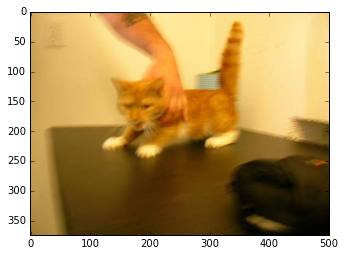

In [3]:
# we are extracting just one file from this zip for now.

with zipfile.ZipFile(train_zip_path) as z:
    # This is a file that we know is in the zip file, check z.namelist() for a list of all files in the zip.
    b = BytesIO(z.read('train/cat.0.jpg'))
    # Downsamples the 3D array to the 2D array required for the examples below.
    color_img = imread(b)
    bw_img = color.rgb2gray(color_img)
    
plt.imshow(color_img)


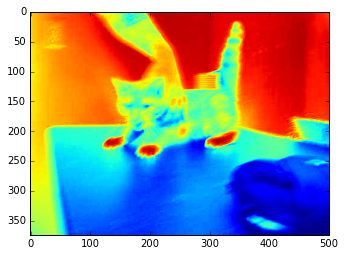

In [4]:
plt.imshow(bw_img)

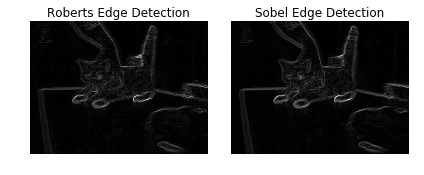

In [5]:
# Yanked from 
# http://scikit-image.org/docs/stable/auto_examples/edges/plot_edge_filter.html#example-edges-plot-edge-filter-py

from skimage.data import camera
from skimage.filters import roberts, sobel, scharr, prewitt


image = bw_img
edge_roberts = roberts(image)
edge_sobel = sobel(image)

fig, (ax0, ax1) = plt.subplots(ncols=2, sharex=True, sharey=True, subplot_kw={'adjustable':'box-forced'})

ax0.imshow(edge_roberts, cmap=plt.cm.gray)
ax0.set_title('Roberts Edge Detection')
ax0.axis('off')

ax1.imshow(edge_sobel, cmap=plt.cm.gray)
ax1.set_title('Sobel Edge Detection')
ax1.axis('off')

plt.tight_layout()

In [17]:
edge_roberts.shape
print(len(list(filter(lambda x: x>0.06, edge_roberts.flatten()))))
edge_roberts.shape

2784


(374, 500)

In [20]:
edge_roberts.min()

0.0